In [1]:
import pickle
import numpy as np
import networkx as nx

### Load data splits and graph

In [2]:
# Paths to load the data
train_data_path = 'ck_data/train_data_70_20_10.pkl'
val_data_path = 'ck_data/val_data_70_20_10.pkl'
test_data_path = 'ck_data/test_data_70_20_10.pkl'

# Load the data splits
with open(train_data_path, 'rb') as f:
    train_data = pickle.load(f)
with open(val_data_path, 'rb') as f:
    val_data = pickle.load(f)
with open(test_data_path, 'rb') as f:
    test_data = pickle.load(f)

adjacency_matrix = np.loadtxt('standard_mesh_adj_matrix.csv', delimiter=',')
G = nx.from_numpy_array(adjacency_matrix)

In [5]:
train_data[0]

Data(x=[468, 3], edge_index=[2, 2644], y=[1], bbox=[6])

In [17]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [18]:
# Convert data lists to DataLoader
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(input_dim=3, hidden_dim=16, output_dim=8).to(device)  # Assuming 8 classes
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    for data in loader:
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)
        correct += pred.eq(data.y).sum().item()
        total += data.num_nodes
    return correct / total

for epoch in range(1, 201):
    train()
    train_acc = evaluate(train_loader)
    val_acc = evaluate(val_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

test_acc = evaluate(test_loader)
print(f'Test Accuracy: {test_acc:.4f}')


ValueError: Expected input batch_size (14976) to match target batch_size (32).

In [ ]:
test_acc = evaluate(test_loader)
print(f'Test Accuracy: {test_acc:.4f}')

In [99]:
import torch
from torch_geometric.loader import DataLoader
import pickle
import numpy as np
import networkx as nx

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

# Load data splits
train_data_path = 'ck_data/train_data_70_20_10.pkl'
val_data_path = 'ck_data/val_data_70_20_10.pkl'
test_data_path = 'ck_data/test_data_70_20_10.pkl'

with open(train_data_path, 'rb') as f:
    train_data = pickle.load(f)
with open(val_data_path, 'rb') as f:
    val_data = pickle.load(f)
with open(test_data_path, 'rb') as f:
    test_data = pickle.load(f)

adjacency_matrix = np.loadtxt('standard_mesh_adj_matrix.csv', delimiter=',')
G = nx.from_numpy_array(adjacency_matrix)

# Add batch attribute to each data object
for data in train_data:
    data.batch = torch.zeros(data.x.size(0), dtype=torch.long)
for data in val_data:
    data.batch = torch.zeros(data.x.size(0), dtype=torch.long)
for data in test_data:
    data.batch = torch.zeros(data.x.size(0), dtype=torch.long)

In [102]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import ChebConv, global_mean_pool
from torch_geometric.loader import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import pandas as pd

class SimpleGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, K):
        super(SimpleGCN, self).__init__()
        self.conv1 = ChebConv(input_dim, hidden_dim, K)
        self.conv2 = ChebConv(hidden_dim, hidden_dim, K)
        self.lin = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)  # Global mean pool to get graph-level representation
        x = self.lin(x)
        return F.log_softmax(x, dim=1)

# Convert data lists to DataLoader
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Define the training and evaluation functions

def train():
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += pred.eq(data.y).sum().item()
        total += data.y.size(0)
    return total_loss / len(train_loader), correct / total

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += pred.eq(data.y).sum().item()
            total += data.y.size(0)
            val_loss += criterion(out, data.y).item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
    return correct / total, val_loss / len(loader), all_labels, all_preds

# Initialize model, optimizer, and criterion
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleGCN(input_dim=3, hidden_dim=32, output_dim=8, K=8).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Calculate class weights
label_counts = np.bincount([data.y.item() for data in train_data])
class_weights = 1.0 / label_counts
class_weights = class_weights / class_weights.sum()
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

early_stopping = EarlyStopping(patience=20, delta=0.001)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
for epoch in range(1, 501):
    train_loss, train_acc = train()
    val_acc, val_loss, _, _ = evaluate(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {int(100 * train_acc):03d}%, Val Acc: {int(100 * val_acc):03d}%')
    
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

Epoch: 001, Train Loss: 2.0999, Val Loss: 2.0776, Train Acc: 006%, Val Acc: 021%
Epoch: 002, Train Loss: 2.0922, Val Loss: 2.0740, Train Acc: 027%, Val Acc: 029%
Epoch: 003, Train Loss: 2.0800, Val Loss: 2.0728, Train Acc: 028%, Val Acc: 027%
Epoch: 004, Train Loss: 2.0847, Val Loss: 2.0802, Train Acc: 009%, Val Acc: 004%
Epoch: 005, Train Loss: 2.0863, Val Loss: 2.0852, Train Acc: 013%, Val Acc: 021%
Epoch: 006, Train Loss: 2.0828, Val Loss: 2.0762, Train Acc: 022%, Val Acc: 021%
Epoch: 007, Train Loss: 2.0757, Val Loss: 2.0754, Train Acc: 022%, Val Acc: 021%
Epoch: 008, Train Loss: 2.0840, Val Loss: 2.0891, Train Acc: 015%, Val Acc: 010%
Epoch: 009, Train Loss: 2.0742, Val Loss: 2.0873, Train Acc: 010%, Val Acc: 010%
Epoch: 010, Train Loss: 2.0866, Val Loss: 2.0779, Train Acc: 014%, Val Acc: 014%
Epoch: 011, Train Loss: 2.0772, Val Loss: 2.0769, Train Acc: 014%, Val Acc: 014%
Epoch: 012, Train Loss: 2.0737, Val Loss: 2.0773, Train Acc: 014%, Val Acc: 008%
Epoch: 013, Train Loss: 2.07

<All keys matched successfully>

Test Accuracy: 31.11%


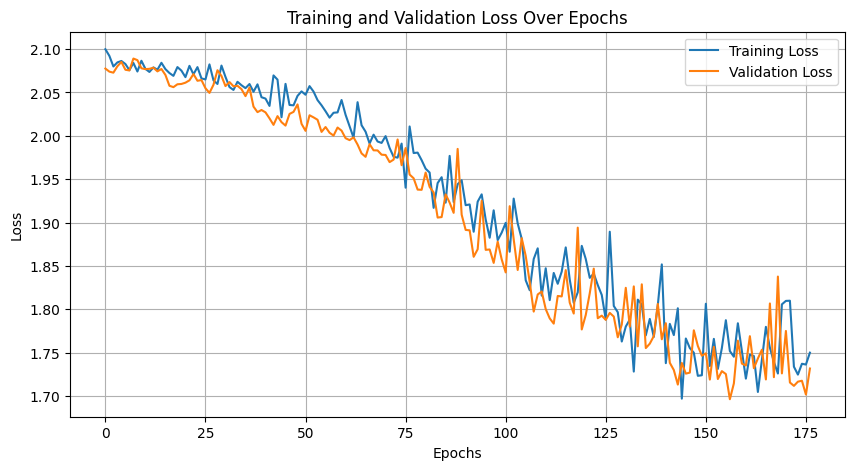

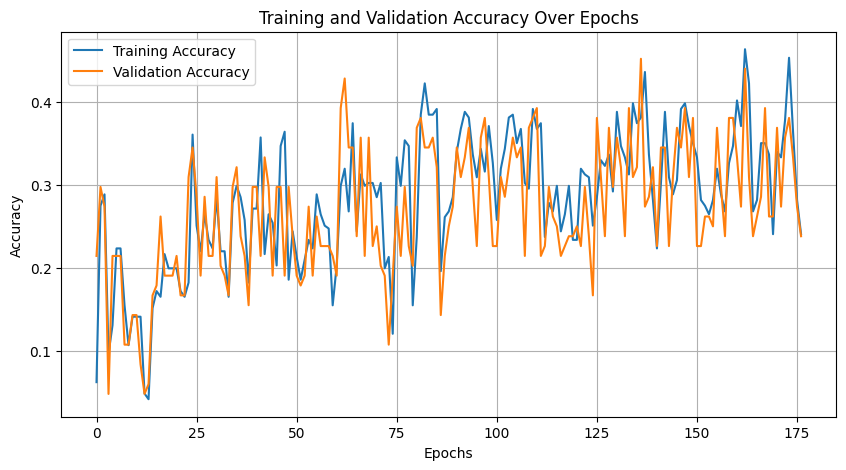

<Figure size 640x480 with 0 Axes>

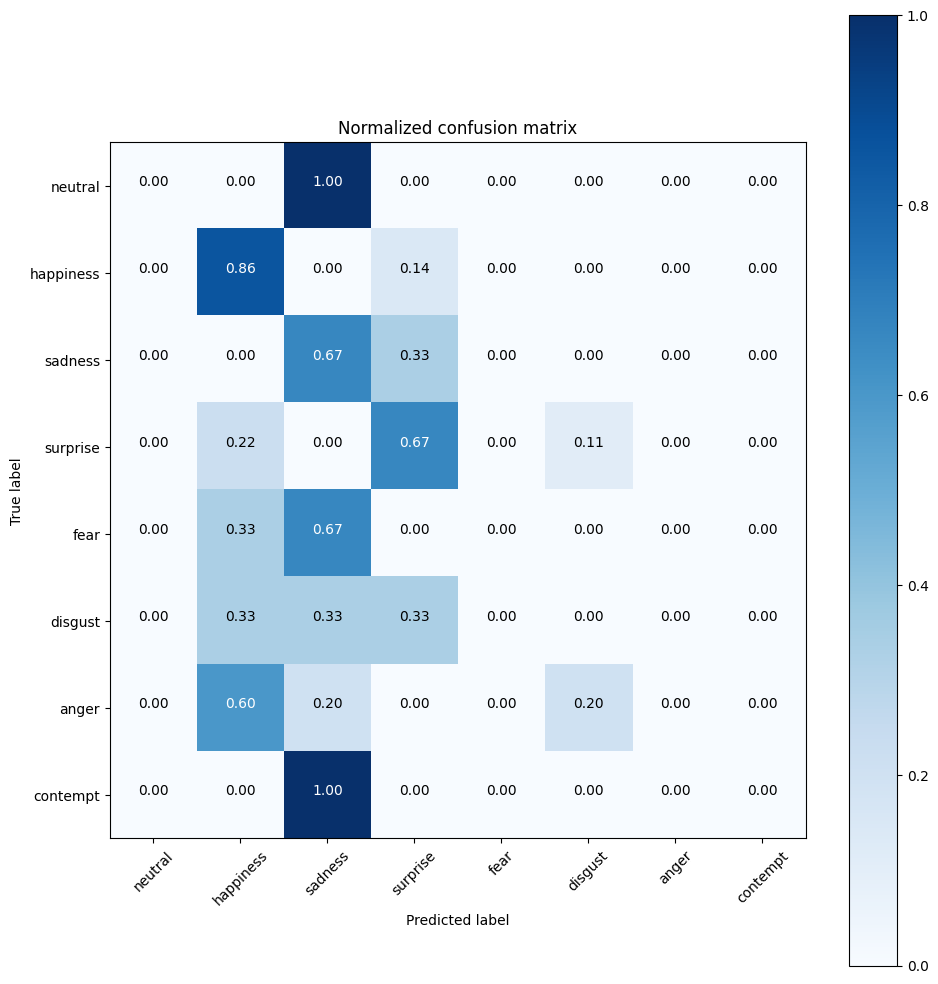

              precision    recall  f1-score    support
neutral        0.000000  0.000000  0.000000  10.000000
happiness      0.428571  0.857143  0.571429   7.000000
sadness        0.105263  0.666667  0.181818   3.000000
surprise       0.600000  0.666667  0.631579   9.000000
fear           0.000000  0.000000  0.000000   3.000000
disgust        0.000000  0.000000  0.000000   6.000000
anger          0.000000  0.000000  0.000000   5.000000
contempt       0.000000  0.000000  0.000000   2.000000
accuracy       0.311111  0.311111  0.311111   0.311111
macro avg      0.141729  0.273810  0.173103  45.000000
weighted avg   0.193684  0.311111  0.227326  45.000000


In [103]:
# Evaluate on the test set
test_acc, _, test_labels, test_preds = evaluate(test_loader)
print(f'Test Accuracy: {100 * test_acc:.2f}%')

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, test_preds)
class_names = ['neutral', 'happiness', 'sadness', 'surprise', 'fear', 'disgust', 'anger', 'contempt']

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

# Classification report
report = classification_report(test_labels, test_preds, target_names=class_names, output_dict=True, zero_division=0)

# Convert report to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()
print(report_df)

# Save report to CSV
report_df.to_csv('classification_report.csv', index=True)

<Figure size 640x480 with 0 Axes>

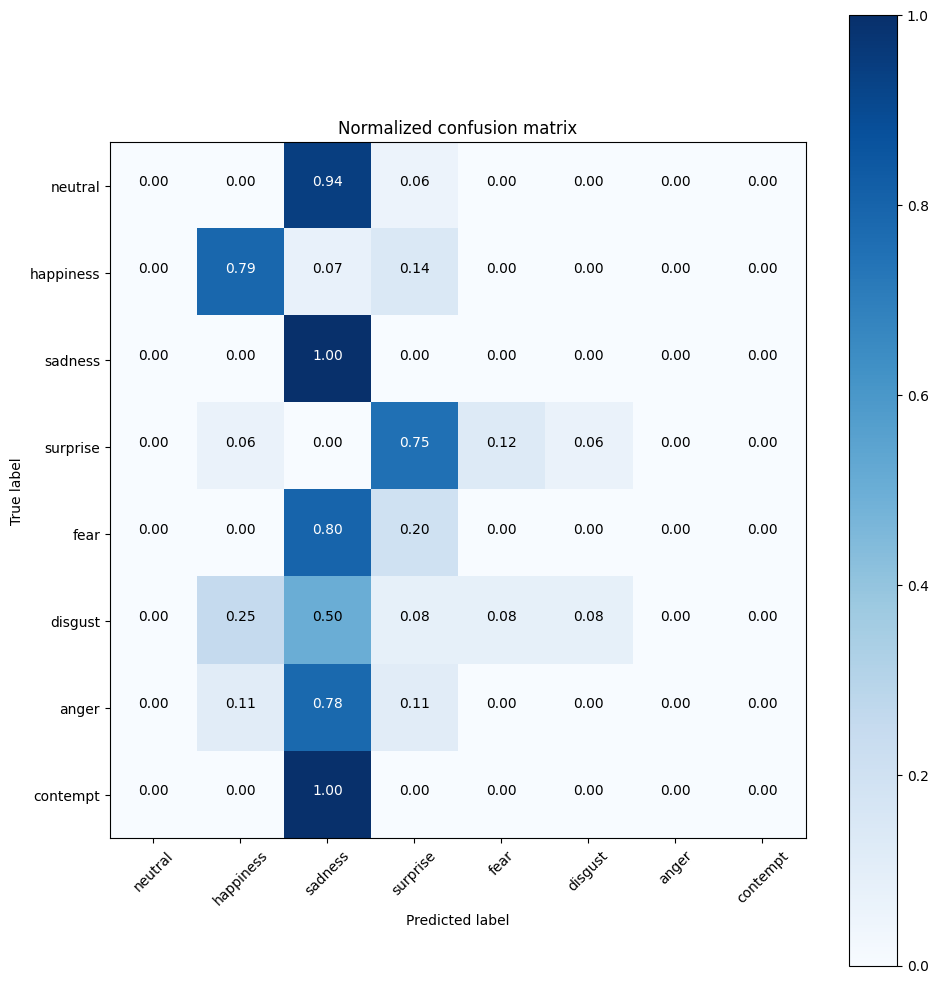

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Assuming you have already trained your model and have the true and predicted labels
# You can get these from the evaluate function, which I assume you have used previously

# Example usage after training and evaluation
val_acc, val_loss, y_true, y_pred = evaluate(val_loader)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()
